In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

def remove_english_stopwords(text):
   stop_words = set(stopwords.words('english'))
   word_tokens = word_tokenize(text)
   filtered_text = [word for word in word_tokens if not word in stop_words]
   return ' '.join(filtered_text)

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def preprocess(text):
    text = remove_nonaplhanumeric(text) 
    text = remove_unnecessary_char(text) 
    text = remove_english_stopwords(text) 
    return text

Train data contain text and labels with answers.

In [4]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv',index_col='id')
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_data['comment_text'] = train_data['comment_text'].apply(preprocess)
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation Why edits made username Hardcore M...,0,0,0,0,0,0
000103f0d9cfb60f,D aww He matches background colour I seemingly...,0,0,0,0,0,0
000113f07ec002fd,Hey man I really trying edit war It guy consta...,0,0,0,0,0,0
0001b41b1c6bb37e,More I make real suggestions improvement I won...,0,0,0,0,0,0
0001d958c54c6e35,You sir hero Any chance remember page,0,0,0,0,0,0


We need to found which length of message we will analyse for prediction

In [6]:
train_data['comment_length'] = train_data['comment_text'].apply(lambda row: len(row))
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0000997932d777bf,Explanation Why edits made username Hardcore M...,0,0,0,0,0,0,188
000103f0d9cfb60f,D aww He matches background colour I seemingly...,0,0,0,0,0,0,90
000113f07ec002fd,Hey man I really trying edit war It guy consta...,0,0,0,0,0,0,149
0001b41b1c6bb37e,More I make real suggestions improvement I won...,0,0,0,0,0,0,398
0001d958c54c6e35,You sir hero Any chance remember page,0,0,0,0,0,0,37


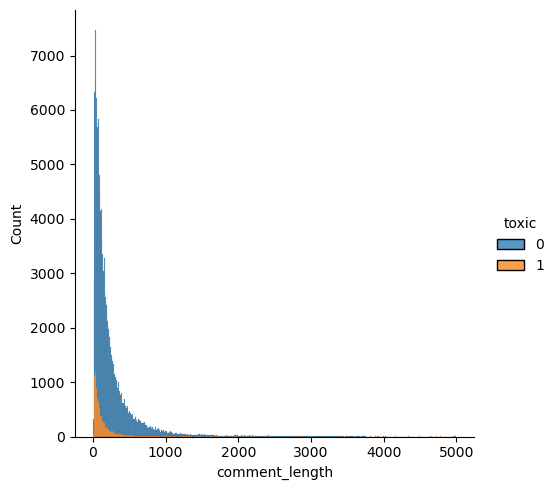

In [7]:
import seaborn as sns
sns.displot(
    data=train_data, 
    x="comment_length", 
    hue='toxic',
    multiple="stack",
)

In [8]:
toxic_data = train_data[train_data['toxic'] == 1]
toxic_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
0005c987bdfc9d4b,Hey talk What exclusive group WP TALIBANS good...,1,0,0,0,0,0,208
0007e25b2121310b,Bye Don look come think comming back Tosser,1,0,0,0,0,0,43
001810bf8c45bf5f,You gay antisemmitian Archangel WHite Tiger Me...,1,0,1,0,1,1,425
00190820581d90ce,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,1,0,1,0,1,0,38


Length of toxic comments: max 5000, min 4, mean 209.4926114816268, median 84.0.

In [9]:
print(
    'max', toxic_data['comment_length'].max(),
    'min', toxic_data['comment_length'].min(),
    'mean', toxic_data['comment_length'].mean(),
    'median', toxic_data['comment_length'].median(),
    '75%', toxic_data['comment_length'].quantile(0.75),
)

max 5000 min 4 mean 209.4926114816268 median 84.0 75% 181.0


 So 300 symbols should be enough.

In [10]:
max_comment_len = 300

Test data contain two files with text and labels separately.

In [11]:
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv',index_col='id')
test_data.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
test_labels_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv',index_col='id')
test_labels_data.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


And some labels has value of -1, that indicates it was not used for scoring; (Note: file added after competition close!)

In [13]:
test_data = test_data.join(test_labels_data)
test_data = test_data[test_data['toxic'] != -1]
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


Solution from "Toxic Comment Classification Challenge" on base of RNN, that taken [3rd place](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644)

Neural networks this is a series of algorithms that seek to identify relationships in a data without being explicitly programmed. 

Neural networks works with numbers, so we need convert messages to numbers.

TextVectorization - A preprocessing layer which maps text features to integer sequences.

max_tokens - Maximum size of the vocabulary for this layer.

adapt - Computes a vocabulary of string terms from tokens in a dataset.

encoder - this is vocabulary created on base of training messages, this is first layer of network that convert coming messages into list of numbers.

Embeding - turns positive integers (indexes) into dense vectors of fixed size. Dense vectors this is modern kind of representing words as vector, this solution have famose effect: King - Man + Woman = Queen.

SpatialDropout1D - dropout, however, it drops entire 1D feature maps instead of individual elements. Dropout removes some neurons from network, this solution help to avoid overfitting.

LSTM - Long Short-Term Memory layer, this is kind of Recurrent Neural Network. return_sequences - whether to return the last output in the output sequence, or the full sequence.

Dense - densely-connected NN layer. Final layer that contain 6 neurons with result.

In [14]:
num_words = 10000
encoder = TextVectorization(max_tokens=num_words)
encoder.adapt(train_data['comment_text'].values)

model_lstm = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        input_length=max_comment_len,
    ),
    SpatialDropout1D(0.5),
    LSTM(40, return_sequences=True),
    LSTM(40),
    Dense(6, activation='sigmoid'),
])

Training of neural network this is a process which reduce difference between correct result and result of neural network. NN reduce error by [gradient descent](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent). 

Loss function - a mesure for difference between real and prediction values. There are different [loss functions](https://kitchell.github.io/DeepLearningTutorial/7lossfunctionsoptimizers.html): 
binary crossentropy, 
categorical crossentropy, 
mean squared error.

Gradient descent have [different optimizations](https://www.geeksforgeeks.org/optimization-techniques-for-gradient-descent/):
SGD,
Adam,
Momentum, 
AdaGrad.


In [15]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [16]:
model_lstm_save_path = '/kaggle/working/toxic_model_lstm'
checkpoint_callback_lstm = ModelCheckpoint(
    model_lstm_save_path, 
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_format='tf',
)

In [17]:
!rm -r /kaggle/working/toxic_model_lstm

rm: cannot remove '/kaggle/working/toxic_model_lstm': No such file or directory


In [18]:
x_train1 = train_data['comment_text'].values
y_train1 = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [19]:
from sklearn.model_selection import train_test_split 
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,train_size=0.8,shuffle=True,random_state=42)

In [20]:
x_train[:2]

array(['Grandma Terri Should Burn Trash Grandma Terri trash I hate Grandma Terri F K HELL 71 74 76 40',
       '9 May 2009 UTC It would easiest admit member involved Portuguese Lodge would requirement acknowledge whether previous account Carlos Botelho good record I would remove sockpuppet template irrelevant WP COI permits people edit articles MSJapan means careful ensuring references back edits NPOV upheld 20 29'],
      dtype=object)

In [21]:
y_train[:2]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [22]:
history_lstm = model_lstm.fit(
    x_train, 
    y_train, 
    validation_data=(x_val,y_val),
    epochs=5, # 15
    batch_size=512,
#     validation_split=0.2,
    callbacks=[checkpoint_callback_lstm],
)

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.8317 - auc: 0.7577
Epoch 1: val_accuracy improved from -inf to 0.96741, saving model to /kaggle/working/toxic_model_lstm
250/250 [==============================] - 104s 366ms/step - loss: 0.1722 - accuracy: 0.8317 - auc: 0.7577 - val_loss: 0.1058 - val_accuracy: 0.9674 - val_auc: 0.9115
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9709 - auc: 0.9614
Epoch 2: val_accuracy improved from 0.96741 to 0.98643, saving model to /kaggle/working/toxic_model_lstm
250/250 [==============================] - 78s 314ms/step - loss: 0.0732 - accuracy: 0.9709 - auc: 0.9614 - val_loss: 0.0586 - val_accuracy: 0.9864 - val_auc: 0.9750
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9794 - auc: 0.9774
Epoch 3: val_accuracy improved from 0.98643 to 0.99329, saving model to /kaggle/working/toxic_model_lstm
250/250 [===================

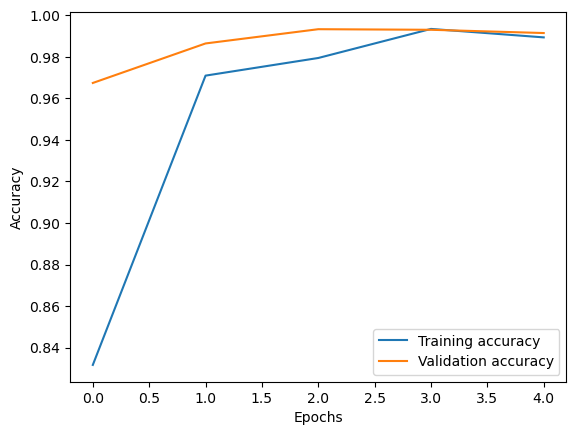

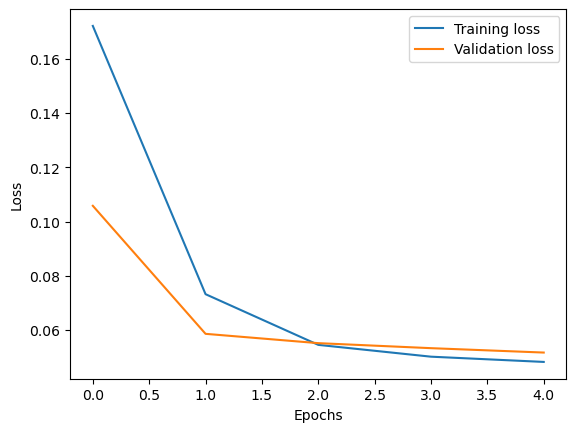

In [23]:
plt.plot(history_lstm.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history_lstm.history['loss'], 
         label='Training loss')
plt.plot(history_lstm.history['val_loss'], 
         label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Get data for testing

In [24]:
x_test = test_data['comment_text'].values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

Check result

In [25]:
model_lstm.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 28s 14ms/step - loss: 0.1030 - accuracy: 0.9965 - auc: 0.9643


[0.10300930589437485, 0.9964988231658936, 0.9642544984817505]

Check result of saved model

In [26]:
saved_model = load_model(model_lstm_save_path)
saved_model.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 31s 14ms/step - loss: 0.0885 - accuracy: 0.9963 - auc: 0.9635


[0.08854078501462936, 0.9962799549102783, 0.9634910821914673]

In [27]:
!zip -r /kaggle/working/toxic_model_lstm.zip /kaggle/working/toxic_model_lstm

  adding: kaggle/working/toxic_model_lstm/ (stored 0%)
  adding: kaggle/working/toxic_model_lstm/keras_metadata.pb (deflated 89%)
  adding: kaggle/working/toxic_model_lstm/fingerprint.pb (stored 0%)
  adding: kaggle/working/toxic_model_lstm/saved_model.pb (deflated 90%)
  adding: kaggle/working/toxic_model_lstm/assets/ (stored 0%)
  adding: kaggle/working/toxic_model_lstm/variables/ (stored 0%)
  adding: kaggle/working/toxic_model_lstm/variables/variables.index (deflated 61%)
  adding: kaggle/working/toxic_model_lstm/variables/variables.data-00000-of-00001 (deflated 6%)


In [28]:
test_data[test_data['toxic']==1][:5]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",1,0,1,0,1,0


In [29]:
test_data[test_data['toxic']==1][:5]['comment_text'].values

array(['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
       'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
       ':Fuck off, you anti-semitic cunt.  |',
       "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
       '::No, he is an arrogant, self serving, immature idiot. Get it right.'],
      dtype=object)

In [30]:
test_labels = saved_model.predict(test_data[test_data['toxic']==1][:5]['comment_text'].values)
for labels in test_labels:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 3s 3s/step
[0.41, 0.0, 0.09, 0.0, 0.08, 0.01]
[0.95, 0.17, 0.86, 0.06, 0.79, 0.14]
[0.93, 0.4, 0.9, 0.14, 0.87, 0.28]
[0.26, 0.0, 0.03, 0.0, 0.06, 0.0]
[0.95, 0.08, 0.79, 0.04, 0.69, 0.09]


In [31]:
quotes = [
    "It takes a great deal of bravery to stand up to your enemies, but a great deal more to stand up to your friends.",
    "No, no. This kind of mark cannot be seen. It lives in your very skin… Love, Harry. Love.",
    "I would trust Hagrid with my own life.",
    "Also, our caretaker, Mr. Filch, has asked me to remind you that the third-floor corridor on the right-hand side is out of bounds to everyone who does not wish to die a most painful death.",
    "It is not our abilities that show what we truly are. It is our choices.",
]
not_toxic_prediction = saved_model.predict(quotes)
for labels in not_toxic_prediction:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 0s 37ms/step
[0.52, 0.0, 0.09, 0.0, 0.12, 0.0]
[0.02, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.62, 0.01, 0.19, 0.01, 0.16, 0.01]
[0.62, 0.0, 0.14, 0.0, 0.16, 0.01]
[0.01, 0.0, 0.0, 0.0, 0.0, 0.0]


In [32]:
quotes = [
    "Maybe If The Fat Lump Had Given This A Squeeze, He'd Have Remembered To Fall On His Fat Ass.",
    "No One Asked Your Opinion, You Filthy Little Mudblood.",
    "Didn't Mummy Ever Tell You It Was Rude To Eavesdrop, Potter? Oh, Yeah. She Was Dead Before You Could Wipe The Drool Off Your Chin.",
    "You're Gonna Regret This! You And Your Bloody Chicken!",
    "I'm going to kill you, Harry Potter. I'm going to destroy you.",
]
toxic_prediction = saved_model.predict(quotes)
for labels in toxic_prediction:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 0s 37ms/step
[0.9, 0.08, 0.73, 0.03, 0.62, 0.08]
[0.82, 0.02, 0.49, 0.01, 0.38, 0.03]
[0.52, 0.0, 0.1, 0.0, 0.13, 0.0]
[0.92, 0.1, 0.78, 0.04, 0.68, 0.09]
[0.95, 0.07, 0.74, 0.03, 0.64, 0.08]


In [33]:

predicts= saved_model.predict(x_test ,verbose=1)

2000/2000 [==============================] - 26s 13ms/step


In [34]:
for i in predicts[:5]:
     print([ round(lbl, 2) for lbl in i])

[0.13, 0.0, 0.01, 0.0, 0.03, 0.0]
[0.2, 0.0, 0.03, 0.0, 0.04, 0.0]
[0.12, 0.0, 0.01, 0.0, 0.03, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts_val = saved_model.predict(x_val, verbose=1)

for threshold in thresholds:
  y_pred_val = (predicts_val > threshold)
  clr = classification_report(y_val, y_pred_val)
  f1 = f1_score(y_val, y_pred_val, average='weighted')
  precision = precision_score(y_val, y_pred_val, average='weighted')
  recall = recall_score(y_val, y_pred_val, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n")


998/998 [==============================] - 9s 9ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      3056
           1       0.25      0.82      0.38       321
           2       0.59      0.92      0.72      1715
           3       0.03      0.14      0.05        74
           4       0.52      0.89      0.66      1614
           5       0.13      0.49      0.21       294

   micro avg       0.50      0.86      0.63      7074
   macro avg       0.36      0.69      0.46      7074
weighted avg       0.55      0.86      0.66      7074
 samples avg       0.06      0.08      0.07      7074

F1 Score: 0.6628224139006188
Precision: 0.5455472236924238
Recall: 0.8618886061634153

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      3056
           1       0.30      0.64      0.41       321
           2       0.66      0.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      3056
           1       0.29      0.08      0.13       321
           2       0.75      0.80      0.77      1715
           3       0.00      0.00      0.00        74
           4       0.69      0.70      0.70      1614
           5       0.14      0.01      0.02       294

   micro avg       0.76      0.68      0.72      7074
   macro avg       0.45      0.39      0.40      7074
weighted avg       0.71      0.68      0.69      7074
 samples avg       0.06      0.06      0.06      7074

F1 Score: 0.6899880325148915
Precision: 0.7131995247430003
Recall: 0.6789652247667515

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      3056
           1       0.25      0.00      0.01       321
           2       0.78      0.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts = saved_model.predict(x_test, verbose=1)

for threshold in thresholds:
  y_pred = (predicts > threshold)
  clr = classification_report(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n")

2000/2000 [==============================] - 26s 13ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.27      0.96      0.43      6090
           1       0.12      0.87      0.22       367
           2       0.32      0.93      0.48      3691
           3       0.02      0.08      0.04       211
           4       0.28      0.93      0.43      3427
           5       0.14      0.50      0.21       712

   micro avg       0.27      0.91      0.41     14498
   macro avg       0.19      0.71      0.30     14498
weighted avg       0.27      0.91      0.42     14498
 samples avg       0.06      0.09      0.07     14498

F1 Score: 0.27074787093170494
Precision: 0.27419729215937144
Recall: 0.9088839839977928

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.36      0.94      0.52      6090
           1       0.18      0.72      0.28       367
           2       0.38      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.3
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.43      0.90      0.58      6090
           1       0.20      0.40      0.27       367
           2       0.44      0.86      0.58      3691
           3       0.03      0.01      0.01       211
           4       0.42      0.81      0.56      3427
           5       0.04      0.01      0.02       712

   micro avg       0.42      0.80      0.55     14498
   macro avg       0.26      0.50      0.34     14498
weighted avg       0.40      0.80      0.53     14498
 samples avg       0.07      0.08      0.07     14498

F1 Score: 0.27074787093170494
Precision: 0.39924469874812096
Recall: 0.7984549593047316

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.47      0.87      0.61      6090
           1       0.06      0.03      0.04       367
           2       0.50      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.50      0.84      0.63      6090
           1       0.00      0.00      0.00       367
           2       0.56      0.77      0.65      3691
           3       0.00      0.00      0.00       211
           4       0.55      0.65      0.60      3427
           5       0.00      0.00      0.00       712

   micro avg       0.53      0.70      0.60     14498
   macro avg       0.27      0.38      0.31     14498
weighted avg       0.48      0.70      0.57     14498
 samples avg       0.07      0.07      0.07     14498

F1 Score: 0.27074787093170494
Precision: 0.48303892905787715
Recall: 0.7040971168437026

Threshold: 0.6
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.54      0.81      0.65      6090
           1       0.00      0.00      0.00       367
           2       0.62      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.60      0.75      0.67      6090
           1       0.00      0.00      0.00       367
           2       0.70      0.57      0.63      3691
           3       0.00      0.00      0.00       211
           4       0.68      0.41      0.51      3427
           5       0.00      0.00      0.00       712

   micro avg       0.64      0.56      0.60     14498
   macro avg       0.33      0.29      0.30     14498
weighted avg       0.59      0.56      0.56     14498
 samples avg       0.07      0.05      0.06     14498

F1 Score: 0.27074787093170494
Precision: 0.591223086500722
Recall: 0.5597323768795696

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      6090
           1       0.00      0.00      0.00       367
           2       0.79      0.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1